In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../Notebook/StudentsPerformance.csv")
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [3]:
df.isnull().sum()

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [5]:
df['gender'].value_counts()

gender
female    518
male      482
Name: count, dtype: int64

In [6]:
for col in df.select_dtypes(include='object').columns:
    print(f"{col}: {df[col].unique()}")

gender: ['female' 'male']
race/ethnicity: ['group B' 'group C' 'group A' 'group D' 'group E']
parental level of education: ["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']
lunch: ['standard' 'free/reduced']
test preparation course: ['none' 'completed']


In [7]:
## Removing whitespaces
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].str.strip().str.lower()

In [8]:
df.columns

Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course', 'math score', 'reading score',
       'writing score'],
      dtype='object')

In [9]:
df.rename(columns={
    'test preparation course':'test_preparation_course',
    'math score': 'math_score',
    'reading score' : 'reading_score',
    'writing score': 'writing_score'
},inplace=True)

In [10]:
df['average_score'] = df[['math_score', 'reading_score', 'writing_score']].mean(axis=1)

In [11]:
df.columns

Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test_preparation_course', 'math_score', 'reading_score',
       'writing_score', 'average_score'],
      dtype='object')

In [12]:
## Independent and dependent features
X_raw = df.drop("average_score", axis=1)
y = df["average_score"]

# One-hot encode categorical columns only
X_categorical = pd.get_dummies(X_raw.select_dtypes(include='object'), drop_first=True)
X_numeric = X_raw[["math_score", "reading_score", "writing_score"]]

# Combine numeric + encoded categorical
X = pd.concat([X_numeric, X_categorical], axis=1)
model_columns = list(X.columns)

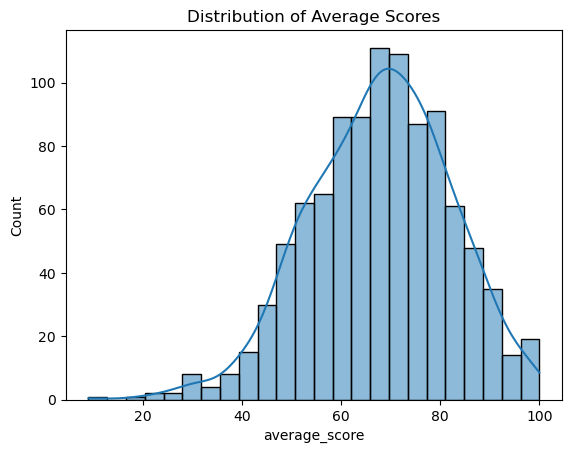

In [13]:
sns.histplot(df['average_score'], kde=True)
plt.title("Distribution of Average Scores")
plt.show()

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [15]:
print("NaNs in X_train:", np.isnan(X_train).sum())
print("NaNs in y_train:", np.isnan(y_train).sum())

NaNs in X_train: math_score                                       0
reading_score                                    0
writing_score                                    0
gender_male                                      0
race/ethnicity_group b                           0
race/ethnicity_group c                           0
race/ethnicity_group d                           0
race/ethnicity_group e                           0
parental level of education_bachelor's degree    0
parental level of education_high school          0
parental level of education_master's degree      0
parental level of education_some college         0
parental level of education_some high school     0
lunch_standard                                   0
test_preparation_course_none                     0
dtype: int64
NaNs in y_train: 0


In [16]:
print("Inf in X_train:", np.isinf(X_train).sum())
print("Inf in y_train:", np.isinf(y_train).sum())

Inf in X_train: math_score                                       0
reading_score                                    0
writing_score                                    0
gender_male                                      0
race/ethnicity_group b                           0
race/ethnicity_group c                           0
race/ethnicity_group d                           0
race/ethnicity_group e                           0
parental level of education_bachelor's degree    0
parental level of education_high school          0
parental level of education_master's degree      0
parental level of education_some college         0
parental level of education_some high school     0
lunch_standard                                   0
test_preparation_course_none                     0
dtype: int64
Inf in y_train: 0


In [17]:
X_train = pd.DataFrame(X_train).replace([np.inf, -np.inf], np.nan).dropna()
y_train = pd.Series(y_train).loc[X_train.index] 

In [18]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer()
X_train = pd.DataFrame(imp.fit_transform(X_train), columns=model_columns)

In [19]:
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
# from xgboost import XGBRegressor

ada = AdaBoostRegressor(random_state=42)
gbr = GradientBoostingRegressor(random_state=42)
# xgb = XGBRegressor(random_state=42)

ada.fit(X_train, y_train)
gbr.fit(X_train, y_train)
# xgb.fit(X_train, y_train)

y_pred_ada = ada.predict(X_test)
y_pred_gbr = gbr.predict(X_test)
# y_pred_xgb = xgb.predict(X_test)

def evaluate_model(name, y_true, y_pred):
    print(f"\n{name}")
    print(f"R2 Score: {r2_score(y_true, y_pred):.4f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.2f}")
    print(f"MSE: {mean_squared_error(y_true, y_pred):.2f}")

evaluate_model("AdaBoost", y_test, y_pred_ada)
evaluate_model("GradientBoosting", y_test, y_pred_gbr)
# evaluate_model("XGBoost", y_test, y_pred_xgb)



AdaBoost
R2 Score: 0.9792
MAE: 1.46
MSE: 4.46

GradientBoosting
R2 Score: 0.9957
MAE: 0.55
MSE: 0.92


In [20]:
ada_params = {
    'n_estimators':[50,100,150,200],
    'learning_rate':[0.01, 0.05, 0.1, 0.5, 1]
}

gbr_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.6, 0.8, 1.0]
}

In [21]:
from sklearn.model_selection import RandomizedSearchCV
random_search_ada = RandomizedSearchCV(ada, param_distributions=ada_params, n_iter=10, cv=5, random_state=42, scoring="r2")
random_search_ada.fit(X_train, y_train)
best_ada = random_search_ada.best_estimator_

y_pred_ada_tuned = best_ada.predict(X_test)
evaluate_model(best_ada, y_test, y_pred_ada_tuned)


AdaBoostRegressor(learning_rate=1, n_estimators=150, random_state=42)
R2 Score: 0.9837
MAE: 1.33
MSE: 3.50


In [22]:
random_search_gbr = RandomizedSearchCV(gbr, param_distributions=gbr_params, n_iter=10, cv=5, random_state=42, scoring="r2")
random_search_gbr.fit(X_train, y_train)
best_gbr = random_search_gbr.best_estimator_

y_pred_gbr_tuned = best_gbr.predict(X_test)
evaluate_model(best_gbr, y_test, y_pred_gbr_tuned)


GradientBoostingRegressor(learning_rate=0.05, max_depth=6, n_estimators=200,
                          random_state=42, subsample=0.6)
R2 Score: 0.9972
MAE: 0.36
MSE: 0.61


Text(0, 0.5, 'Predicted')

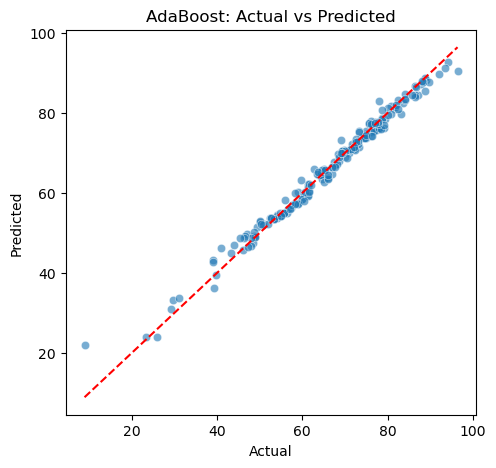

In [23]:
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
sns.scatterplot(x=y_test, y=y_pred_ada_tuned, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.title("AdaBoost: Actual vs Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")

Text(0, 0.5, 'Predicted')

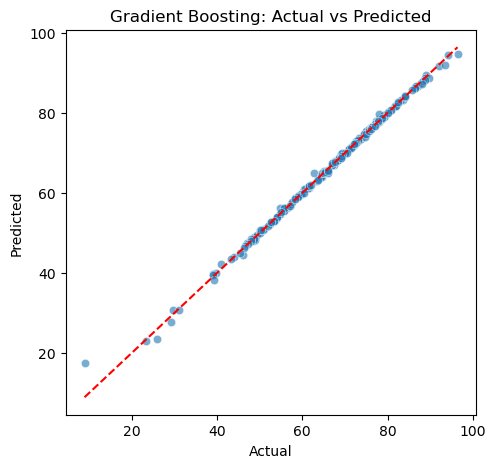

In [24]:
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 2)
sns.scatterplot(x=y_test, y=y_pred_gbr_tuned, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.title("Gradient Boosting: Actual vs Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")

In [25]:
import joblib

joblib.dump(best_ada, "../models/ada_boost_model.pkl")
joblib.dump(best_gbr, "../models/gradient_boost_model.pkl")


['../models/gradient_boost_model.pkl']

In [26]:
joblib.dump(model_columns, "../models/model_columns.pkl")

['../models/model_columns.pkl']

In [27]:
print(X.columns)

Index(['math_score', 'reading_score', 'writing_score', 'gender_male',
       'race/ethnicity_group b', 'race/ethnicity_group c',
       'race/ethnicity_group d', 'race/ethnicity_group e',
       'parental level of education_bachelor's degree',
       'parental level of education_high school',
       'parental level of education_master's degree',
       'parental level of education_some college',
       'parental level of education_some high school', 'lunch_standard',
       'test_preparation_course_none'],
      dtype='object')
